In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(linewidth=200) # Sets message printing width for easier readability

#-- Add utilityFunctions/ to easily use utility .py files --#
import os.path
from os import path
import sys
sys.path.append("utilityFunctions/")
sys.path.append("plottingUtils/")

In [2]:
#-- Boolean flags to change options --#
CONVERTPARAMS = True # Converts parameters of multinest scan to ones we would like to plot
EXPBOUNDS     = True
DEBUG         = True

# NOTE: This notebook assumes 2d scan in fpi_pow and bsmall_pow, do more general case later

In [3]:
#-- Option parameters, here for convenience --#
txtFilename         = 'ulyssesScanResults/ULSNEST_test.txt' # Text file with Ulysses multinest scan results
scanParamsNameList  = ['fpi_pow', 'bsmall_pow']  # Parameters which were scanned over corresponding to columns 2: in txtFilename in order


# Note on units of scan parameters
# fpi_pow    = log_10(fpi/GeV)
# bsmall_pow = log_10(bsmall)

# Load data from multinest scan

In [4]:
#-- Open data file --#
df = np.loadtxt(txtFilename, dtype=np.double)

#-- Set posterior and likelihood values --#
dfDict = {}
dfDict["posterior"]  = df[:,0]
dfDict["likelihood"] = df[:,1]

#-- Set parameter values into a dictionary corresponding to scanParamsNameList and an overall dfDict--#
# Note that order in scanParamsNameList must be the same as in txtFilename 
# Note also that scans are done in log scale e.g. we scan in fpi_pow = log_10(fpi/GeV)

scanParamsDict = {}
for i in range(2, df.shape[1]):
    scanParamsDict[scanParamsNameList[i-2]] = df[:,i]
    dfDict[scanParamsNameList[i-2]]         = df[:,i]

if(DEBUG):
    print("Complete data dictionary keys:       ",list(dfDict.keys()))
    print("Scan parameter data dictionary keys: ",list(scanParamsDict.keys()))
    print("")
    
    from printUtils import prettyPrintColumns
    prettyPrintColumns(dfDict)
    
    #print("   posterior,        likelihood,        fpi_pow,      bsmall_pow")#!
    #print(df[0:5,:])

Complete data dictionary keys:        ['posterior', 'likelihood', 'fpi_pow', 'bsmall_pow']
Scan parameter data dictionary keys:  ['fpi_pow', 'bsmall_pow']

           posterior           likelihood              fpi_pow           bsmall_pow
1.0542080797071043e-99    449.8126620347343    4.396944665908814  -2.7695024609565735
2.0266786915279793e-99    448.5004450529332   4.6573137465817895  -3.1578672088843716
2.4318010955363865e-99   448.13097738538863   4.6287765324115755  -3.3832911252975464
2.618022595642328e-99   447.97840313749765   4.6769528687000275   -2.989453375339508
9.212712410137282e-99    445.4570731061954    4.629676461219788  -3.3744972348213196


In [5]:
L = ["posteior", "likelihood"]
newDumStringArr = np.array([L])
for row in newDumStringArr:
    #print('{: >20} {: >20}'.format("posteior", "likelihood"))
    print('{: >20} {: >20}'.format(*row))

            posteior           likelihood


# Convert parameters to those we want to plot

Jacobian for a transformation from $x_1,...,x_n \rightarrow y_1,...,y_n$ is defined as 

$J = |\frac{\partial(y_1,...,y_n)}{\partial(x_1,...,x_n)}|$

then

$ d y_1...d y_n = J d x_1...d x_n$ 

Therefore the posterior $p(x | z)$ where $z$ is the data and $x$ are the parameters transforms to $p(y | z) = J p(x | z)$. 

And the likelihood $p(z | x)$ to $p(z | y) = J p(z | x)$. 

https://mathworld.wolfram.com/Jacobian.html

There are 3 possible cases assuming the scan parameters bsmall_pow and fpi_pow enumerated below.

##### Case 1: If plotting in log_10 still
- $x = \{$ bsmall_pow, fpi_pow$\}$
- $y = \{$ mD_pow, fpi_pow $\}$ where mD_pow $= {\rm log}_{10}(4 \pi) +$ fpi_pow $+$ bsmall_pow

##### Case 2: If NOT plotting in log_10
- $x = \{$ bsmall_pow, fpi_pow$\}$
- $y = \{$ mD, fpi (GeV)$\}$ where mD $= 4 \pi 10.^{{\rm fpi \_ pow}} 10.^{{\rm bsmall \_ pow}}$ and fpi $= 10.^{{\rm fpi \_ pow}}$

##### Case 3: If NOT plotting in log_10 and want fpi in TeV
- $x = \{$ bsmall_pow, fpi_pow$\}$
- $y = \{$ mD, fpi (TeV)$\}$ where mD $= 4 \pi 10.^{{\rm fpi \_ pow}} 10.^{{\rm bsmall \_ pow}}$ and fpi $= 10.^{{\rm fpi \_ pow}-3}$

In [6]:
CASE  = 3 # Must be 1, 2, or 3

In [7]:
from jacobianConvert import JacobianConvert2D
dfDict_new = JacobianConvert2D(dfDict, CASE=CASE, CONVERTPARAMS=True)

In [8]:
if DEBUG:
    print("New complete data dictionary keys: ",list(dfDict_new.keys()))
    print("")
    from printUtils import prettyPrintColumns
    prettyPrintColumns(dfDict_new)

New complete data dictionary keys:  ['posterior', 'likelihood', 'fpi_TeV', 'mD_GeV']

           posterior           likelihood              fpi_TeV               mD_GeV
7.429412167319832e-95    31700038.43324611    24.94276907250267    532.9077902550276
1.937253378919703e-94   42871077.998591095    45.42696753613911   396.87742998017296
1.2129174123457323e-94   22351575.812673885    42.53794764668961    221.1542405072793
4.0370766388257165e-94     69079737.8531075    47.52836435431661    611.9407259606074
4.7085202572199463e-94    22766841.71899786   42.626184582442846   226.14609369647027


# Estimate posterior PDF via weighted KDE estimate

The following code is to create a 2D plot of the posterior and likelihood. The first cell sets many parameters that will be used later.

In [9]:
#-- Define desired x and y axis --#
xkey = 'mD_GeV' # The key of the desired x-axis value
ykey = 'fpi_TeV' # The key of the desired y-axis value

#-- Define plotting range --#
# Default is min and max of chosen x and y axis
xmin = dfDict_new[xkey].min()
xmax = dfDict_new[xkey].max()
ymin = dfDict_new[ykey].min()
ymax = dfDict_new[ykey].max()
axisRange = [xmin, xmax, ymin, ymax]

#-- Define number of meshgrid points to use in plot --#
# This is the number of times the kernel functions will be sampled
# Ex. 100j will sample kernel on a 100x100 grid over the specified xy range
# Note this is complex (*j) because ...
gMesh = 100j 

if DEBUG:
    print(xmin, xmax, ymin, ymax)

89.62692912351645 1857.1027244701118 21.679322218456406 50.06409839697919


In [10]:
#-- Create kernel functions which approximate our posterior and likelihood PDFs --#
from statUtils import estimateKDE_2D
kernel_posterior, kernel_likelihood = estimateKDE_2D(dfDict_new, xkey, ykey)

### Evaluate posterior PDF estimate on grid for plotting and evaluation

In [11]:
from statUtils import evaluateKernelOnGrid
posteriorDict  = evaluateKernelOnGrid(kernel_posterior, axisRange, gMesh)
likelihoodDict = evaluateKernelOnGrid(kernel_likelihood, axisRange, gMesh)

if DEBUG:
    print("posterior keys:  ", list(posteriorDict.keys()))
    print("likelihood keys: ", list(posteriorDict.keys()))
    print("")
    print(posteriorDict["pdf"].shape)
    print(likelihoodDict["pdf"].shape)

posterior keys:   ['X', 'Y', 'pdf']
likelihood keys:  ['X', 'Y', 'pdf']

(100, 100)
(100, 100)


# Calculate 1 and 2 sigma contours

Calculates critical probability alpha such that $\int_{p(x,y) \geq p_{crit}} p(x,y) dx dy = 1 - \alpha$.

Where $\alpha = 0.32 \rightarrow 1 \sigma$ and $\alpha = 0.05 \rightarrow 2 \sigma$.

In [12]:
from statUtils import findCriticalDensityVals
posteriorDict["critDensity"]  = findCriticalDensityVals(posteriorDict["pdf"])
likelihoodDict["critDensity"] = findCriticalDensityVals(likelihoodDict["pdf"])

if DEBUG:
    print(posteriorDict["critDensity"])
    print(likelihoodDict["critDensity"])

[0.00022069090134926977, 0.001008303757852845]
[6.091845227549693e-05, 0.00011963177708724543]


# Define experimental bounds

In [13]:
expBoundDict = {}

#-- Bound on DM mass from LHC --#
# https://arxiv.org/pdf/1908.08215.pdf
# https://arxiv.org/pdf/1807.07799.pdf
expBoundDict["LHC_mD_GeV"] = 420 # GeV

# Plot everything

In [14]:
from plotUtils import plotPDF

## Plot the posterior

The posterior is the probability of $\theta$ being the statistical parameters underlying the data, $D$. In this case our $\theta$ are e.g. $m_\chi$ and $f_\Pi$. We plot a heatmap of $p(\theta \mid D)$ with curves whose interior denotes the regions of parameter space which agree with experiments at the 1 and 2 $\sigma$ level.

In [15]:
#-- Set stylistic elements of plot --#
posteriorPlotArgs = {'plotTitle': 'Posterior PDF',
                    'xAxisTitle': r'$m_\chi$ [GeV]',
                    'yAxisTitle': r'$f_\Pi$ [TeV]',
                    'LHC_frac': 0.1} # Fraction above ymin that "LHC bound" is printed

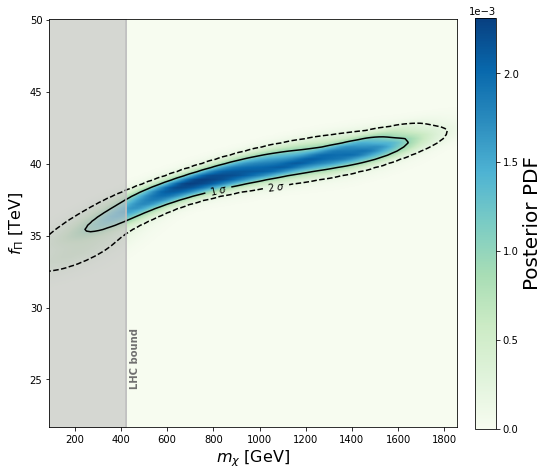

In [16]:
plotPDF(posteriorDict["X"], posteriorDict["Y"], posteriorDict["pdf"], 
        axisRange, posteriorDict["critDensity"], expBoundDict, posteriorPlotArgs)

## Plot the likelihood

The likelihood is the likelihood of $\theta$ having generated the data, $D$. In this case our $\theta$ are e.g. $m_\chi$ and $f_\Pi$. We plot a heatmap of $p(D \mid \theta)$ with curves whose interior denotes the regions of parameter space which agree with experiments at the 1 and 2 $\sigma$ level. (Jessica: Check that the last part is statistically sound...)

In [20]:
#-- Set stylistic elements of plot --#
likelihoodPlotArgs = {'plotTitle': 'Likelihood PDF',
                    'xAxisTitle': r'$m_\chi$ [GeV]',
                    'yAxisTitle': r'$f_\Pi$ [TeV]',
                    'LHC_frac': 0.45} # Fraction above ymin that "LHC bound" is printed

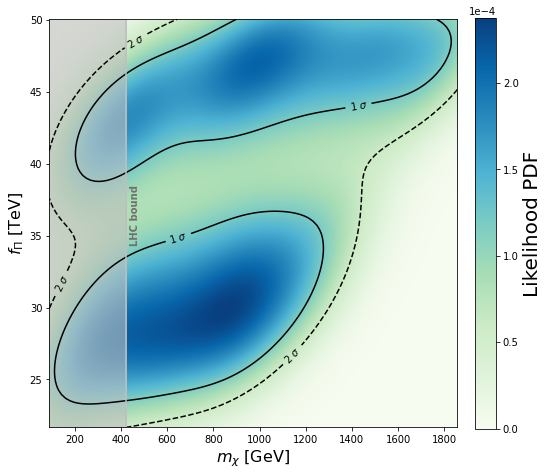

In [21]:
plotPDF(likelihoodDict["X"], likelihoodDict["Y"], likelihoodDict["pdf"], 
        axisRange, likelihoodDict["critDensity"], expBoundDict, likelihoodPlotArgs)